## Business use case:
+ An FMCG company entered into the instant noodles business two years back. Their higher management has noticed that there is a miss match in the demand and supply. Where the demand is high, supply is pretty low and where the demand is low, supply is pretty high. In both ways, it is an inventory cost loss to the company; hence, the higher management wants to optimize the supply quantity in every warehouse in the entire country.


### Goal & Objective: 
+ To build a model that will determine the optimum weight of the product to be shipped each time to the warehouse.
+ Also, to analyze the demand pattern in different pockets of the country so management can drive the advertisement campaign, particularly in those pockets.



In [1]:
#importing libraries
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
%matplotlib inline

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

In [2]:
# !pip install termcolor
from termcolor import colored


# Figure&Display options
plt.rcParams["figure.figsize"] = (16, 15)
pd.set_option('max_colwidth',200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:

# import colorama
# from colorama import Fore, Style  # makes strings colored

# from termcolor import cprint


In [4]:
#!pip install cufflinks
# !pip install plotly

In [5]:
# Importing plotly and cufflinks in offline mode
# # import cufflinks as cf
# import plotly.offline
# cf.go_offline()
# cf.set_config_file(offline=True, world_readable=True)
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

## DATA COLLECTION AND PREPROCESSING

### Data structure

In [6]:
fmcg_data = pd.read_csv("Data.csv")
fmcg_data.head()

Ware_house_ID WH_Manager_ID Location_type WH_capacity_size   zone  \
0     WH_100000     EID_50000         Urban            Small   West   
1     WH_100001     EID_50001         Rural            Large  North   
2     WH_100002     EID_50002         Rural              Mid  South   
3     WH_100003     EID_50003         Rural              Mid  North   
4     WH_100004     EID_50004         Rural            Large  North   

  WH_regional_zone  num_refill_req_l3m  transport_issue_l1y  \
0           Zone 6                   3                    1   
1           Zone 5                   0                    0   
2           Zone 2                   1                    0   
3           Zone 3                   7                    4   
4           Zone 5                   3                    1   

   Competitor_in_mkt  retail_shop_num  wh_owner_type  distributor_num  \
0                  2             4651         Rented               24   
1                  4             6217  Company Owned               47   
2                  4             4306  Company Owned               64   
3                  2             6000         Rented               50   
4                  2             4740  Company Owned               42   

   flood_impacted  flood_proof  electric_supply  dist_from_hub  workers_num  \
0               0            1                1             91        29.00   
1               0            0                1            210        31.00   
2               0            0                0            161        37.00   
3               0            0                0            103        21.00   
4               1            0                1            112        25.00   

   wh_est_year  storage_issue_reported_l3m  temp_reg_mach  \
0          NaN                          13              0   
1          NaN                           4              0   
2          NaN                          17              0   
3          NaN                          17              1   
4      2009.00                          18              0   

  approved_wh_govt_certificate  wh_breakdown_l3m  govt_check_l3m  \
0                            A                 5              15   
1                            A                 3              17   
2                            A                 6              22   
3                           A+                 3              27   
4                            C                 6              24   

   product_wg_ton  
0           17115  
1            5074  
2           23137  
3           22115  
4           24071

In [7]:
df_dtypes_table = pd.DataFrame(fmcg_data.dtypes).reset_index()
df_dtypes_table.columns = ['Column Name', 'Data Type']
df_dtypes_table

Column Name Data Type
0                  Ware_house_ID    object
1                  WH_Manager_ID    object
2                  Location_type    object
3               WH_capacity_size    object
4                           zone    object
5               WH_regional_zone    object
6             num_refill_req_l3m     int64
7            transport_issue_l1y     int64
8              Competitor_in_mkt     int64
9                retail_shop_num     int64
10                 wh_owner_type    object
11               distributor_num     int64
12                flood_impacted     int64
13                   flood_proof     int64
14               electric_supply     int64
15                 dist_from_hub     int64
16                   workers_num   float64
17                   wh_est_year   float64
18    storage_issue_reported_l3m     int64
19                 temp_reg_mach     int64
20  approved_wh_govt_certificate    object
21              wh_breakdown_l3m     int64
22                govt_check_l3m     int64
23                product_wg_ton     int64

### Data preparation and cleaning

In [8]:
def missing_values(df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.shape[0]).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values[missing_values['Missing_Number']>0]

In [9]:
def first_looking(df):
    print(colored("Shape:", attrs=['bold']), df.shape,'\n', 
          colored('*'*100, 'red', attrs=['bold']),
          colored("\nInfo:\n", attrs=['bold']), sep='')
    print(df.info(), '\n', 
          colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Number of Uniques:\n", attrs=['bold']), df.nunique(),'\n',
          colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Missing Values:\n", attrs=['bold']), missing_values(df),'\n', 
          colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("All Columns:", attrs=['bold']), list(df.columns),'\n', 
          colored('*'*100, 'red', attrs=['bold']), sep='')

    df.columns= df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')
    print(colored("Columns after rename:", attrs=['bold']), list(df.columns),'\n',
          colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Descriptive Statistics \n", attrs=['bold']), df.describe().round(2),'\n',
          colored('*'*100, 'red', attrs=['bold']), sep='') # Gives a statstical breakdown of the data.
    print(colored("Descriptive Statistics (Categorical Columns) \n", attrs=['bold']), df.describe(include=object).T,'\n',
          colored('*'*100, 'red', attrs=['bold']), sep='') # Gives a statstical breakdown of the data.

In [10]:
# To view summary information about the columns
def first_look(df,col):
    print("column name    : ", col)
    print("per_of_nulls   : ", "%", round(df[col].isnull().sum()/df.shape[0]*100, 2))
    print("num_of_nulls   : ", df[col].isnull().sum())
    print("num_of_uniques : ", df[col].nunique())
    print("Value counts   : \n", df[col].value_counts(dropna = False)) 
    print(colored("-"*100, 'red',attrs=['bold']), sep="")

In [11]:
def multicolinearity_control(df):
    feature =[]
    collinear=[]
    for col in df.corr(numeric_only=True).columns:
        for i in df.corr(numeric_only=True).index:
            if (abs(df.corr(numeric_only=True)[col][i])> .75 and abs(df.corr(numeric_only=True)[col][i]) < 1):
                    feature.append(col)
                    collinear.append(i)
                    print(colored(f"Multicolinearity alert in between:{col} - {i}", 
                                  "red", attrs=['bold']), df.shape,'\n',
                                  colored('*'*100, 'red', attrs=['bold']), sep='')
    else:
        print("No Multicolinearity")

In [12]:
def duplicate_values(df):
    print(colored("Duplicate check...", attrs=['bold']), sep='')
    duplicate_values = df.duplicated(subset=None, keep='first').sum()
    if duplicate_values > 0:
        df.drop_duplicates(keep='first', inplace=True)
        print(duplicate_values, colored(" Duplicates were dropped!"),'\n',
              colored('*'*100, 'red', attrs=['bold']), sep='')
    else:
        print(colored("There are no duplicates"),'\n',
              colored('*'*100, 'red', attrs=['bold']), sep='')

In [13]:
def drop_columns(df, drop_columns):
    if drop_columns !=[]:
        df.drop(drop_columns, axis=1, inplace=True)
        print(drop_columns, 'were dropped')
    else:
        print(colored('We will now check the missing values and if necessary, the realted columns will be dropped!', attrs=['bold']),'\n',
              colored('*'*100, 'red', attrs=['bold']), sep='')

In [14]:
def drop_null(df, limit):
    print('Shape:', df.shape)
    for i in df.isnull().sum().index:
        percent = (df.isnull().sum()[i]/df.shape[0]*100)
        if percent >limit:
            print(f'{i} has {percent} of null values and was dropped')
            df.drop(i, axis=1, inplace=True)
            print('new shape:', df.shape)       
    print(colored("New shape after missing value control:"),'\n', df.shape)

In [15]:
first_looking(fmcg_data)

Shape:(25000, 24)
****************************************************************************************************
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ware_house_ID                 25000 non-null  object 
 1   WH_Manager_ID                 25000 non-null  object 
 2   Location_type                 25000 non-null  object 
 3   WH_capacity_size              25000 non-null  object 
 4   zone                          25000 non-null  object 
 5   WH_regional_zone              25000 non-null  object 
 6   num_refill_req_l3m            25000 non-null  int64  
 7   transport_issue_l1y           25000 non-null  int64  
 8   Competitor_in_mkt             25000 non-null  int64  
 9   retail_shop_num               25000 non-null  int64  
 10  wh_owner_type                 25000 non-null  object

In [16]:
duplicate_values(fmcg_data)

Duplicate check...
There are no duplicates
****************************************************************************************************


### Checking for null values and dropping the columns with more than 30% null

<Figure size 500x500 with 0 Axes>

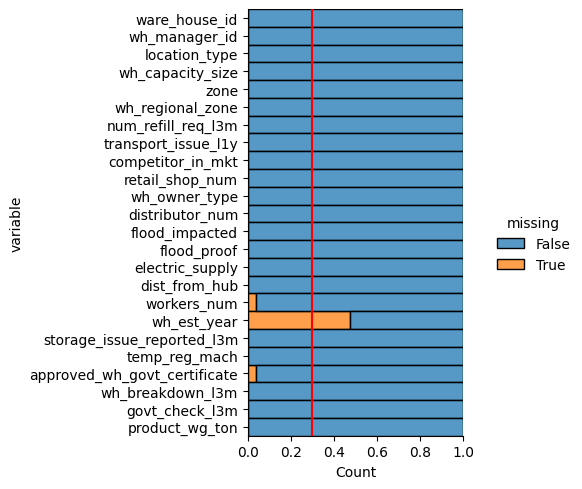

In [17]:
plt.figure(figsize = (5, 5))

sns.displot(
    data = fmcg_data.isnull().melt(value_name = "missing"),
    y = "variable",
    hue = "missing",
    multiple = "fill",
    height = 5)

plt.axvline(0.3, color = "r");

In [18]:
drop_null(fmcg_data,30)

Shape: (25000, 24)
wh_est_year has 47.524 of null values and was dropped
new shape: (25000, 23)
New shape after missing value control: 
 (25000, 23)


In [19]:
fmcg_data.corr(numeric_only=True)

num_refill_req_l3m  transport_issue_l1y  \
num_refill_req_l3m                        1.00                 0.02   
transport_issue_l1y                       0.02                 1.00   
competitor_in_mkt                         0.00                -0.01   
retail_shop_num                          -0.00                -0.00   
distributor_num                           0.00                 0.01   
flood_impacted                           -0.01                -0.01   
flood_proof                              -0.00                 0.00   
electric_supply                          -0.01                -0.01   
dist_from_hub                             0.00                 0.01   
workers_num                              -0.01                -0.01   
storage_issue_reported_l3m               -0.01                -0.14   
temp_reg_mach                             0.26                 0.02   
wh_breakdown_l3m                          0.00                 0.01   
govt_check_l3m                           -0.00                 0.00   
product_wg_ton                            0.00                -0.17   

                            competitor_in_mkt  retail_shop_num  \
num_refill_req_l3m                       0.00            -0.00   
transport_issue_l1y                     -0.01            -0.00   
competitor_in_mkt                        1.00            -0.16   
retail_shop_num                         -0.16             1.00   
distributor_num                         -0.00            -0.00   
flood_impacted                           0.01            -0.00   
flood_proof                             -0.00             0.01   
electric_supply                          0.00            -0.01   
dist_from_hub                            0.01             0.00   
workers_num                              0.00            -0.01   
storage_issue_reported_l3m               0.01            -0.01   
temp_reg_mach                            0.01            -0.00   
wh_breakdown_l3m                         0.01            -0.01   
govt_check_l3m                          -0.04             0.05   
product_wg_ton                           0.01            -0.01   

                            distributor_num  flood_impacted  flood_proof  \
num_refill_req_l3m                     0.00           -0.01        -0.00   
transport_issue_l1y                    0.01           -0.01         0.00   
competitor_in_mkt                     -0.00            0.01        -0.00   
retail_shop_num                       -0.00           -0.00         0.01   
distributor_num                        1.00            0.00        -0.00   
flood_impacted                         0.00            1.00         0.11   
flood_proof                           -0.00            0.11         1.00   
electric_supply                        0.00            0.16         0.11   
dist_from_hub                         -0.01            0.00        -0.01   
workers_num                           -0.01            0.17         0.04   
storage_issue_reported_l3m             0.00           -0.00        -0.00   
temp_reg_mach                          0.00           -0.01         0.01   
wh_breakdown_l3m                       0.00           -0.00        -0.01   
govt_check_l3m                        -0.01            0.00        -0.00   
product_wg_ton                         0.00           -0.00        -0.00   

                            electric_supply  dist_from_hub  workers_num  \
num_refill_req_l3m                    -0.01           0.00        -0.01   
transport_issue_l1y                   -0.01           0.01        -0.01   
competitor_in_mkt                      0.00           0.01         0.00   
retail_shop_num                       -0.01           0.00        -0.01   
distributor_num                        0.00          -0.01        -0.01   
flood_impacted                         0.16           0.00         0.17   
flood_proof                            0.11          -0.01         0.04   
electric_supply  

In [20]:
multicolinearity_control(fmcg_data)

Multicolinearity alert in between:storage_issue_reported_l3m - product_wg_ton(25000, 23)
****************************************************************************************************
Multicolinearity alert in between:product_wg_ton - storage_issue_reported_l3m(25000, 23)
****************************************************************************************************
No Multicolinearity


In [21]:
first_look(fmcg_data,"workers_num")

column name    :  workers_num
per_of_nulls   :  % 3.96
num_of_nulls   :  990
num_of_uniques :  60
Value counts   : 
 workers_num
28.00    1491
27.00    1447
29.00    1402
26.00    1290
25.00    1268
24.00    1228
30.00    1202
31.00    1132
23.00    1077
32.00    1077
NaN       990
22.00     959
33.00     916
21.00     826
34.00     796
20.00     783
36.00     671
35.00     670
19.00     590
18.00     559
37.00     506
17.00     445
39.00     419
38.00     417
40.00     381
16.00     328
42.00     298
41.00     240
43.00     212
44.00     204
45.00     175
15.00     155
14.00     104
46.00      91
50.00      73
48.00      71
49.00      65
55.00      50
47.00      47
53.00      45
56.00      40
54.00      39
51.00      30
52.00      29
57.00      24
13.00      24
58.00      20
12.00      15
61.00      14
60.00      10
67.00       5
65.00       5
72.00       5
64.00       5
11.00       5
92.00       5
78.00       5
10.00       5
98.00       5
62.00       5
63.00       5
Name: count, dtyp

In [22]:
first_look(fmcg_data,"approved_wh_govt_certificate")

column name    :  approved_wh_govt_certificate
per_of_nulls   :  % 3.63
num_of_nulls   :  908
num_of_uniques :  5
Value counts   : 
 approved_wh_govt_certificate
C      5501
B+     4917
B      4812
A      4671
A+     4191
NaN     908
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------


In [23]:
first_look(fmcg_data,"zone")

column name    :  zone
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  4
Value counts   : 
 zone
North    10278
West      7931
South     6362
East       429
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------


In [24]:
first_look(fmcg_data, "wh_regional_zone")

column name    :  wh_regional_zone
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  6
Value counts   : 
 wh_regional_zone
Zone 6    8339
Zone 5    4587
Zone 4    4176
Zone 2    2963
Zone 3    2881
Zone 1    2054
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------


In [25]:
#sum(fmcg_data["wh_regional_zone"].value_counts().values)

## DATA EXPLORATION AND VISUALIZATION

### To check the number of warehouses in each zone

In [1]:
region_zone_df = fmcg_data.groupby(["zone","wh_regional_zone"],as_index=False)["ware_house_id"].count()
region_zone_df.columns = ["Zone", "WH Regional Zone", "Count"]
region_zone_df["Total warehouses"] = region_zone_df.groupby("WH Regional Zone")["Count"].transform("sum")
region_zone_df["Percentage"] = round((region_zone_df["Count"]/region_zone_df["Total warehouses"])*100,2)
region_zone_df.sort_values(by="Percentage", ascending=False, inplace=True)

NameError: name 'fmcg_data' is not defined

In [ ]:
region_zone_pivot_df=region_zone_df.pivot_table(values="Percentage" , index=["Zone"], columns=["WH Regional Zone"])
region_zone_pivot_df.style.highlight_max(color = 'lightgreen').highlight_min(color = 'coral').highlight_null('yellow')

In [40]:
zone_df=fmcg_data.groupby(["zone","wh_capacity_size","wh_regional_zone"],as_index=False)["wh_regional_zone"].count()
zone_df.rename(columns={"zone":"Zone", "wh_capacity_size":"WareHouse Size", "wh_regional_zone":"No of WareHouses"},inplace=True)

In [41]:
nzone_df = fmcg_data.groupby(["zone","wh_regional_zone"],as_index=False)["ware_house_id"].count()
nzone_df.sort_values("ware_house_id", ascending=False)

zone wh_regional_zone  ware_house_id
10  North           Zone 6           4519
22   West           Zone 6           2398
20   West           Zone 4           1966
9   North           Zone 5           1917
21   West           Zone 5           1489
12  South           Zone 2           1444
16  South           Zone 6           1364
8   North           Zone 4           1186
15  South           Zone 5           1107
7   North           Zone 3            961
19   West           Zone 3            923
13  South           Zone 3            885
14  South           Zone 4            882
6   North           Zone 2            854
5   North           Zone 1            841
11  South           Zone 1            680
18   West           Zone 2            665
17   West           Zone 1            490
2    East           Zone 4            142
1    East           Zone 3            112
3    East           Zone 5             74
4    East           Zone 6             58
0    East           Zone 1             43

In [2]:
zone_df["Total Warehouses"] = zone_df.groupby(["WareHouse Size"])["No of WareHouses"].transform('sum')
zone_df["percentage [%]"] = round((zone_df["No of WareHouses"]/zone_df["Total Warehouses"])*100,2)
zone_df.sort_values(by="percentage [%]", ascending=False, inplace=True)

NameError: name 'zone_df' is not defined

In [44]:
zone_df.pivot_table(index="Zone", columns="WareHouse Size", values="percentage [%]").style.highlight_max(color = 'lightgreen').highlight_min(color = 'coral').highlight_null('yellow')

In [46]:
fig = px.bar(zone_df, x=zone_df["Zone"], y=zone_df["No of WareHouses"], color=zone_df["WareHouse Size"], title="No of WareHouses in each Zone according to size", color_discrete_sequence=["darkslateblue", "deepskyblue", "gainsboro"])
fig.show()

In North Zone maximum number of warehouses are present followed by West and South Zones and in East Zone it is the least. 

Also most of the warehouses are Mid and Large size.

### To check the number of warehouses in each type of location

In [48]:
loc_df=fmcg_data.groupby(["location_type","wh_capacity_size"],as_index=False)["wh_regional_zone"].count()

In [49]:
loc_df.columns=["Location Type","WareHouse size", "# of WareHouses"]

In [50]:
fig = px.bar(loc_df, x="Location Type", y="# of WareHouses", color="WareHouse size", title="No of WareHouses in different location",
            color_discrete_sequence=["green","orange", "grey" ])
fig.show()

Maximum number of warehouses are present in Rural areas.

### Why Rural type has more number of warehouses?


In [51]:
retail_df = fmcg_data.groupby("location_type", as_index=False)["retail_shop_num"].sum()
retail_df.columns= ["Type of Location", "# of retail shop" ]
fig = px.pie(retail_df, 
             values  = "# of retail shop", 
             names = "Type of Location", 
             color="Type of Location",
             title = 'Number of retail shops', color_discrete_map={"Rural":"darkorange", "Urban":'dodgerblue'})

fig.show()

There are more retail shops in the rural location as compared to urban area. So, number of warehouses are more in rural areas

## Number of warehouses refilled in last 3 months

In [52]:
refill_df=fmcg_data.groupby(["wh_regional_zone","zone"],as_index=False)["num_refill_req_l3m"].count()
refill_df.columns=["WareHouse Zone","Zone", "# of WareHouses refilled in last 3 months"]
refill_df["Total warehouses"]=refill_df.groupby("WareHouse Zone")["# of WareHouses refilled in last 3 months"].transform("sum")
refill_df["Percentage"] = round((refill_df["# of WareHouses refilled in last 3 months"]/refill_df["Total warehouses"])*100,2)

In [54]:
refill_df.pivot_table(index="Zone", columns="WareHouse Zone", values="Percentage").style.highlight_max(color = 'lightgreen').highlight_min(color = 'coral').highlight_null('yellow')

In [55]:
fig = px.funnel(refill_df, x="WareHouse Zone", y="# of WareHouses refilled in last 3 months", color="Zone", title="No of WareHouses refilled in different zones in last 3 months",
               color_discrete_sequence = ['red', 'blue', 'orange', 'green'])
fig.show()

Zone 6 in North has maximum number of refillings and Zone 1 in west has less number of refillings

### Number of retail shops in each zone

In [56]:
retail_zone_df = fmcg_data.groupby(["zone","wh_regional_zone" ], as_index=False)[["retail_shop_num"]].count()
retail_zone_df.columns = ["Zone", "WareHouse Zone","# of retail shop"]
fig = px.treemap(retail_zone_df, path=["Zone"], values="# of retail shop", width=950, height=600)
fig.update_layout(title_text="# of retail shop",
                  title_x=0.5, title_font=dict(size=20)
                  )
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

In [58]:
retail_zone_df = fmcg_data.groupby(["zone","wh_regional_zone" ], as_index=False)[["retail_shop_num"]].count()
retail_zone_df.columns = ["Zone", "WareHouse Zone","# of retail shop"]
retail_zone_df["Total retail shops"] = retail_zone_df.groupby("WareHouse Zone")["# of retail shop"].transform("sum")
retail_zone_df["Percentage"] = round((retail_zone_df["# of retail shop"]/retail_zone_df["Total retail shops"])*100,2)

In [60]:
retail_zone_df.pivot_table(index="Zone", columns="WareHouse Zone", values = "Percentage").style.highlight_max(color = 'lightgreen').highlight_min(color = 'coral').highlight_null(color='yellow')

In [61]:
px.bar(retail_zone_df, x="Zone", y="# of retail shop", color="WareHouse Zone", title="No of retail shops under each zone")

All the above plots indicates that zones with maximum number of retail shops has more number of warehouses inturn has more refillings in last 3 months. 

For example Zone 6 of North zone has maximum number of retail shops which concludes that it has more number of warehouses and maximum refillings in last 3 months and so on

### Product weight shipped to each zone

In [62]:
weight_df = fmcg_data.groupby(["zone", "wh_regional_zone"], as_index=False)["product_wg_ton"].sum().sort_values(by="product_wg_ton", ascending=False)
weight_df.columns=["Zone", "Regional Zone", "Product Weight (Ton)"]
px.bar(data_frame=weight_df, x="Zone", y="Product Weight (Ton)", color="Regional Zone",title="Product weight shipped to each zone")

In [64]:
weight_df["Total weight"] = weight_df.groupby("Regional Zone")["Product Weight (Ton)"].transform("sum")
weight_df["percentage"] = round(weight_df["Product Weight (Ton)"]/weight_df["Total weight"]*100,2)
weight_df.pivot_table(index="Zone", columns="Regional Zone", values="percentage").style.highlight_max(color = 'lightgreen').highlight_min(color = 'coral').highlight_null(color='yellow')

In [65]:
weight_df

Zone Regional Zone  Product Weight (Ton)  Total weight  percentage
10  North        Zone 6             100249991     184421651       54.36
22   West        Zone 6              52661774     184421651       28.56
20   West        Zone 4              43804669      92596029       47.31
9   North        Zone 5              42893115     101017613       42.46
12  South        Zone 2              32467899      66580768       48.76
21   West        Zone 5              32242727     101017613       31.92
16  South        Zone 6              30235650     184421651       16.39
8   North        Zone 4              26254519      92596029       28.35
15  South        Zone 5              24113697     101017613       23.87
7   North        Zone 3              21335735      63290230       33.71
19   West        Zone 3              20617692      63290230       32.58
14  South        Zone 4              19230670      92596029       20.77
6   North        Zone 2              18966332      66580768       28.49
13  South        Zone 3              18810119      63290230       29.72
5   North        Zone 1              18466131      44659532       41.35
18   West        Zone 2              15146537      66580768       22.75
11  South        Zone 1              14682866      44659532       32.88
17   West        Zone 1              10638197      44659532       23.82
2    East        Zone 4               3306171      92596029        3.57
1    East        Zone 3               2526684      63290230        3.99
3    East        Zone 5               1768074     101017613        1.75
4    East        Zone 6               1274236     184421651        0.69
0    East        Zone 1                872338      44659532        1.95

### Number of Competitors in Market

In [66]:
comp_df = fmcg_data.groupby(["zone","wh_regional_zone" ], as_index=False)["competitor_in_mkt"].sum().sort_values(by="competitor_in_mkt", ascending=False)
comp_df.columns= ["Zone", "Regional Zone", "# Competitors in market"]
px.bar(data_frame=comp_df, x="Zone", y="# Competitors in market", color="Regional Zone", title="Number of Competitors in Market")

In [68]:
comp_df["Total weight"] = comp_df.groupby("Regional Zone")["# Competitors in market"].transform("sum")
comp_df["percentage"] = round(comp_df["# Competitors in market"]/comp_df["Total weight"]*100,2)
comp_df.pivot_table(index="Zone", columns="Regional Zone", values="percentage").style.highlight_max(color = 'lightgreen').highlight_min(color = 'coral').highlight_null(color='yellow')

Based on the competitors we come into certain conclusions in zones such as North zone 6:

**Differentiate your product**: Identify what makes your instant noodles unique and highlight those features that set you apart from your competitors. For example, you could offer a wider variety of flavors or emphasize that your noodles are made with healthier ingredients.

**Focus on quality**: Ensure that your product is of high quality and consistently meets customer expectations. This will help build trust with your customers and keep them coming back.

**Offer competitive pricing**: Pricing is an important factor in the instant noodles market. Research your competitors' prices and adjust your pricing strategy accordingly.

**Invest in marketing**: Effective marketing is crucial to help you get noticed in a crowded market. Invest in targeted advertising, social media marketing, and other promotional activities to reach your target audience specially in zone 6 of north warehouses

**Build strong distribution channels**: Ensure that your product is widely available by building strong distribution channels. This can include partnerships with retailers, online marketplaces, or direct-to-consumer sales.


### Number of distributors  in each zone

In [69]:
dist_df = fmcg_data.groupby(["zone","wh_regional_zone"],as_index=False)["distributor_num"].sum().sort_values(by="distributor_num", ascending = False)
dist_df

zone wh_regional_zone  distributor_num
10  North           Zone 6           190695
22   West           Zone 6           101613
20   West           Zone 4            83464
9   North           Zone 5            82251
21   West           Zone 5            63376
12  South           Zone 2            60376
16  South           Zone 6            58348
8   North           Zone 4            50621
15  South           Zone 5            46605
7   North           Zone 3            40228
19   West           Zone 3            39749
14  South           Zone 4            37743
13  South           Zone 3            37651
6   North           Zone 2            36416
5   North           Zone 1            35610
18   West           Zone 2            28800
11  South           Zone 1            28394
17   West           Zone 1            20757
2    East           Zone 4             5641
1    East           Zone 3             4853
3    East           Zone 5             3048
4    East           Zone 6             2300
0    East           Zone 1             1914

In [70]:
dist_df["Total weight"] = dist_df.groupby("wh_regional_zone")["distributor_num"].transform("sum")
dist_df["percentage"] = round(dist_df["distributor_num"]/dist_df["Total weight"]*100,2)
dist_df.pivot_table(index="zone", columns="wh_regional_zone", values="percentage").style.highlight_max(color = 'lightgreen').highlight_min(color = 'coral').highlight_null(color='yellow')

## Problems faced in warehouse

### Transport issues in different zones

In [71]:
first_look(fmcg_data, "transport_issue_l1y")

column name    :  transport_issue_l1y
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  6
Value counts   : 
 transport_issue_l1y
0    15215
1     4644
2     2198
3     1818
4      777
5      348
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------


In [72]:
transport_issue_df = fmcg_data.groupby(["zone", "wh_regional_zone"], as_index=False)["transport_issue_l1y"].sum().sort_values(by="transport_issue_l1y", ascending=False)
transport_issue_df["total issues"] =  transport_issue_df.groupby("wh_regional_zone")["transport_issue_l1y"].transform("sum")
transport_issue_df["percentage"] = round(transport_issue_df["transport_issue_l1y"]/transport_issue_df["total issues"]*100,2)

In [73]:
transport_issue_df.pivot_table(index="zone", columns="wh_regional_zone", values = "percentage").style.highlight_max(color = 'lightgreen').highlight_min(color = 'coral').highlight_null(color='yellow')
transport_issue_df.sort_values("transport_issue_l1y", ascending=False)

zone wh_regional_zone  transport_issue_l1y  total issues  percentage
10  North           Zone 6                 3446          6429       53.60
22   West           Zone 6                 1819          6429       28.29
9   North           Zone 5                 1539          3499       43.98
20   West           Zone 4                 1530          3316       46.14
21   West           Zone 5                 1134          3499       32.41
16  South           Zone 6                 1120          6429       17.42
12  South           Zone 2                 1061          2192       48.40
8   North           Zone 4                  962          3316       29.01
15  South           Zone 5                  775          3499       22.15
7   North           Zone 3                  737          2269       32.48
13  South           Zone 3                  725          2269       31.95
19   West           Zone 3                  721          2269       31.78
14  South           Zone 4                  702          3316       21.17
5   North           Zone 1                  695          1637       42.46
6   North           Zone 2                  649          2192       29.61
11  South           Zone 1                  545          1637       33.29
18   West           Zone 2                  482          2192       21.99
17   West           Zone 1                  361          1637       22.05
2    East           Zone 4                  122          3316        3.68
1    East           Zone 3                   86          2269        3.79
3    East           Zone 5                   51          3499        1.46
4    East           Zone 6                   44          6429        0.68
0    East           Zone 1                   36          1637        2.20

Transport issue may be one of the reason that certain demands are not met in certain region. For example North of Zone 6 has more number of retail shops and more demand for the product. Also it has maximum transport issues in last 1 year. If there are transport issues, required number of products cannot be shipped to the warehouse which might cut of the supply which leads to the demand supply imbalance.


To mitigate the impact of transport issues on the supply chain, companies can adopt various strategies such as improving their transportation infrastructure, diversifying their transportation options, and investing in technology that helps optimize their logistics operations. By doing so, they can ensure that products are delivered to their customers in a timely and cost-effective manner, and avoid demand-supply imbalances that can hurt their bottom line.

In [74]:
first_look(fmcg_data,"flood_impacted")

column name    :  flood_impacted
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2
Value counts   : 
 flood_impacted
0    22546
1     2454
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------


In [75]:
floodImp_df = fmcg_data.groupby(["zone","wh_regional_zone"],as_index=False)["flood_impacted"].sum().sort_values(by="flood_impacted", ascending = False)

In [76]:
floodProof_df = fmcg_data.groupby(["zone","wh_regional_zone"],as_index=False)["flood_proof"].sum().sort_values(by="flood_proof", ascending = False)

In [77]:
storage_df = fmcg_data.groupby(["zone","wh_regional_zone"],as_index=False)["storage_issue_reported_l3m"].sum().sort_values(by="storage_issue_reported_l3m", ascending = False)

In [78]:
breakdown_df = fmcg_data.groupby(["zone","wh_regional_zone"],as_index=False)["wh_breakdown_l3m"].sum().sort_values(by="wh_breakdown_l3m", ascending = False)

In [79]:
elec_supply_df = fmcg_data[fmcg_data["electric_supply"]==0]
elec_prob_df=elec_supply_df.groupby(["zone", "wh_regional_zone"], as_index=False)["ware_house_id"].count().sort_values(by="ware_house_id", ascending=False)

In [80]:
temp_df = fmcg_data[fmcg_data["temp_reg_mach"]==0]
temp_prob_df = temp_df.groupby(["zone", "wh_regional_zone"], as_index=False)["temp_reg_mach"].count().sort_values(by="temp_reg_mach", ascending=False)

In [81]:
govt_certi_df = fmcg_data[fmcg_data["approved_wh_govt_certificate"].isna()]
govt_certi_df.groupby(["zone", "wh_regional_zone"], as_index=False)["govt_check_l3m"].count().sort_values(by="govt_check_l3m", ascending = False)

zone wh_regional_zone  govt_check_l3m
10  North           Zone 6             165
22   West           Zone 6              75
9   North           Zone 5              68
20   West           Zone 4              61
21   West           Zone 5              60
16  South           Zone 6              58
8   North           Zone 4              56
12  South           Zone 2              48
13  South           Zone 3              41
6   North           Zone 2              41
11  South           Zone 1              34
15  South           Zone 5              33
5   North           Zone 1              31
14  South           Zone 4              31
7   North           Zone 3              28
19   West           Zone 3              28
18   West           Zone 2              25
17   West           Zone 1              17
1    East           Zone 3               2
2    East           Zone 4               2
0    East           Zone 1               2
4    East           Zone 6               1
3    East           Zone 5               1

In [82]:
govt_check_df=fmcg_data.groupby(["zone", "wh_regional_zone"], as_index=False)["govt_check_l3m"].count().sort_values(by="govt_check_l3m", ascending = False)

<Figure size 1000x1000 with 0 Axes>

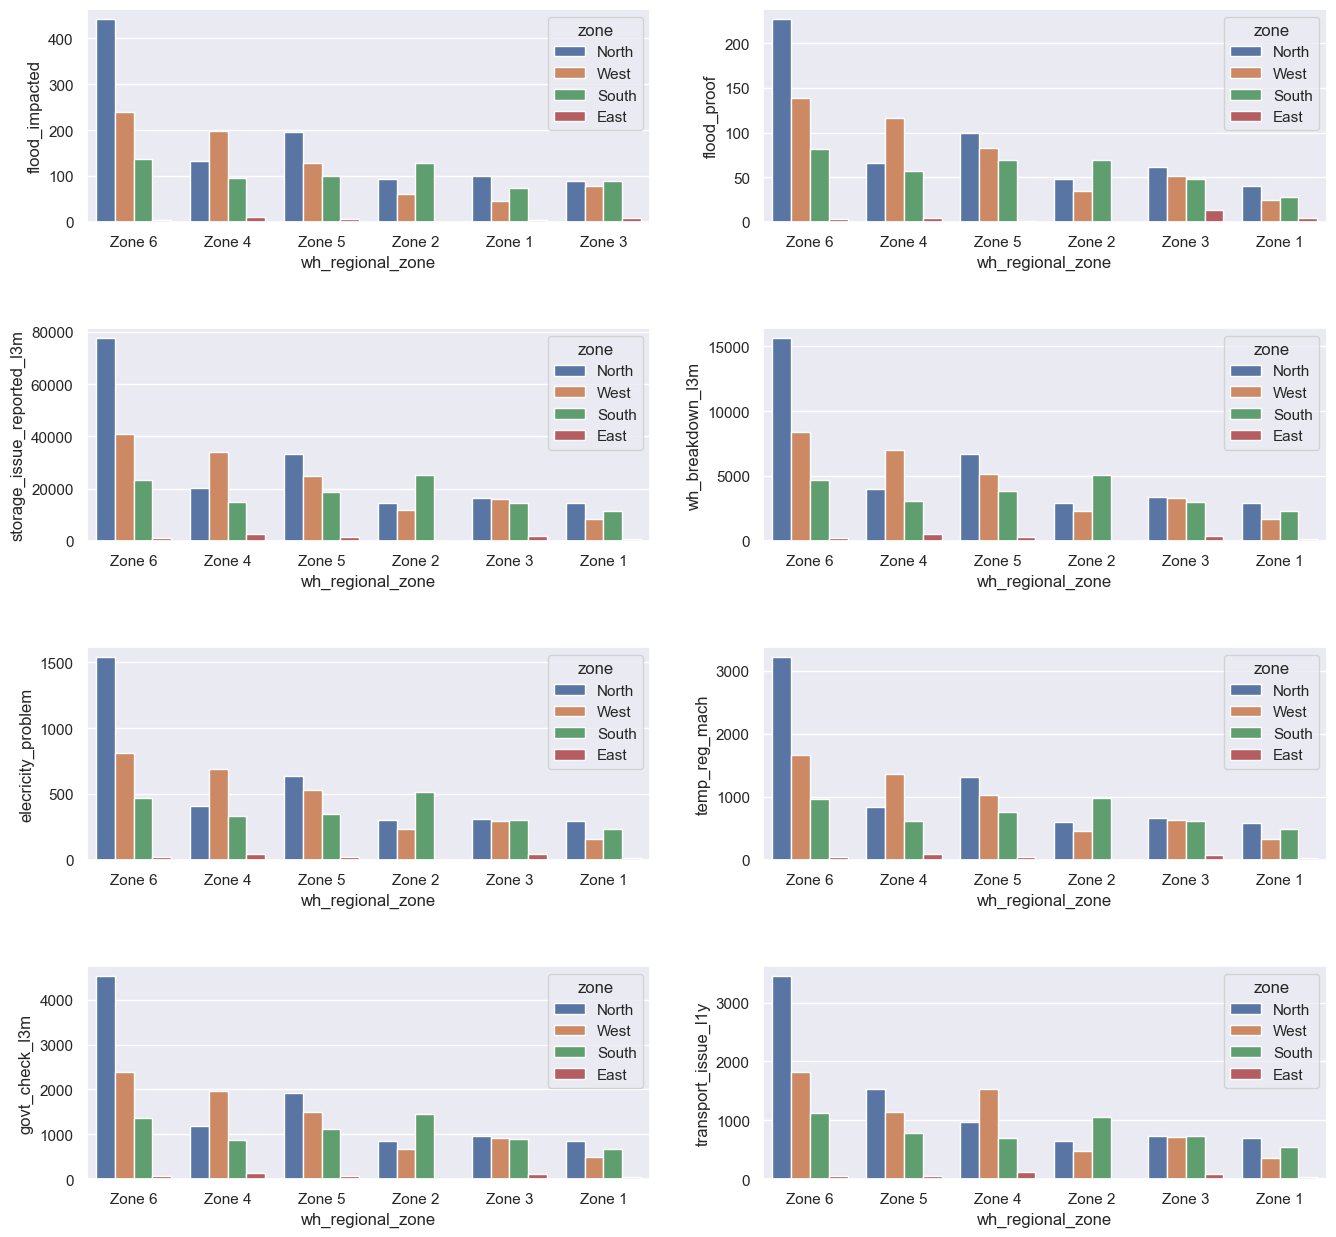

In [83]:
sns.set()
plt.figure(figsize=(10,10))
#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(4, 2)

#create boxplot in each subplot
sns.barplot(data=floodImp_df, x='wh_regional_zone', y='flood_impacted', ax=axes[0,0], hue = "zone", )
sns.barplot(data=floodProof_df, x='wh_regional_zone', y="flood_proof", ax=axes[0,1], hue = "zone")
sns.barplot(data=storage_df, x='wh_regional_zone', y="storage_issue_reported_l3m", ax=axes[1,0], hue = "zone")
sns.barplot(data=breakdown_df, x='wh_regional_zone', y="wh_breakdown_l3m", ax=axes[1,1], hue = "zone")
ax=sns.barplot(data=elec_prob_df, x='wh_regional_zone', y="ware_house_id", ax=axes[2,0], hue = "zone")
ax.set_ylabel("elecricity_problem")
sns.barplot(data=temp_prob_df, x='wh_regional_zone', y="temp_reg_mach", ax=axes[2,1], hue = "zone")
sns.barplot(data=govt_check_df, x='wh_regional_zone', y="govt_check_l3m", ax=axes[3,0], hue = "zone")
sns.barplot(data=transport_issue_df, x='wh_regional_zone', y="transport_issue_l1y", ax=axes[3,1], hue = "zone");


fig.subplots_adjust(hspace=0.5,bottom=.1)

Problems like floods, storage issue, WH breakdown, electricty issue, temperature regulator issue, will have a significant impact on businesses, and it's important to address them as soon as possible in order to minimize any negative consequences.

Overall, it's important for businesses to have contingency plans in place to address these issues and minimize their impact. This may involve investing in flood prevention measures, implementing proper inventory management systems, and conducting regular maintenance and repairs on warehouse equipment. Additionally, it's important for businesses to have clear communication with customers and supply chain partners to mitigate any disruptions caused by these issues.

Also,  Number of time government Officers have been visited the warehouse to check the quality and expire of stored food in last 3 months may be because of complaints recieved from the dissatisfied customers which may be the cause for less demand of the product even though supply is high.


In [3]:
first_look(fmcg_data,'dist_from_hub')

NameError: name 'first_look' is not defined

### Distance and refills

In [85]:
fmcg_data["dist_from_hub"].describe()

count   25000.00
mean      163.54
std        62.72
min        55.00
25%       109.00
50%       164.00
75%       218.00
max       271.00
Name: dist_from_hub, dtype: float64

<Axes: xlabel='dist_from_hub', ylabel='Count'>

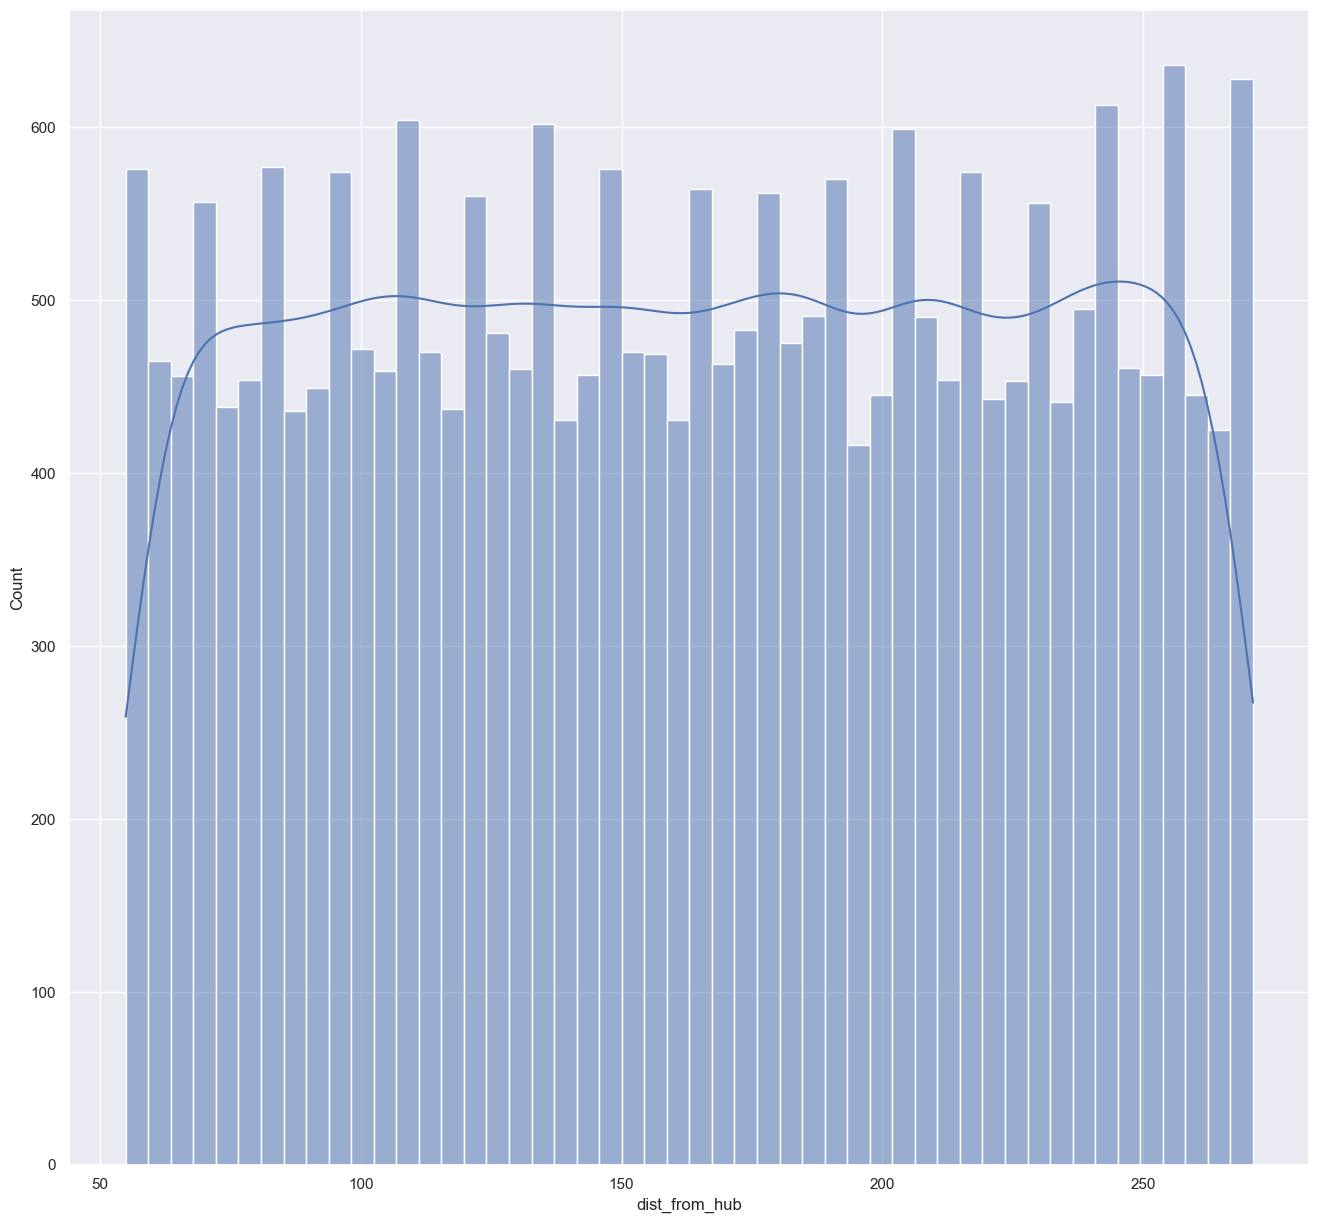

In [86]:
sns.histplot(fmcg_data["dist_from_hub"], bins=50, kde=True)

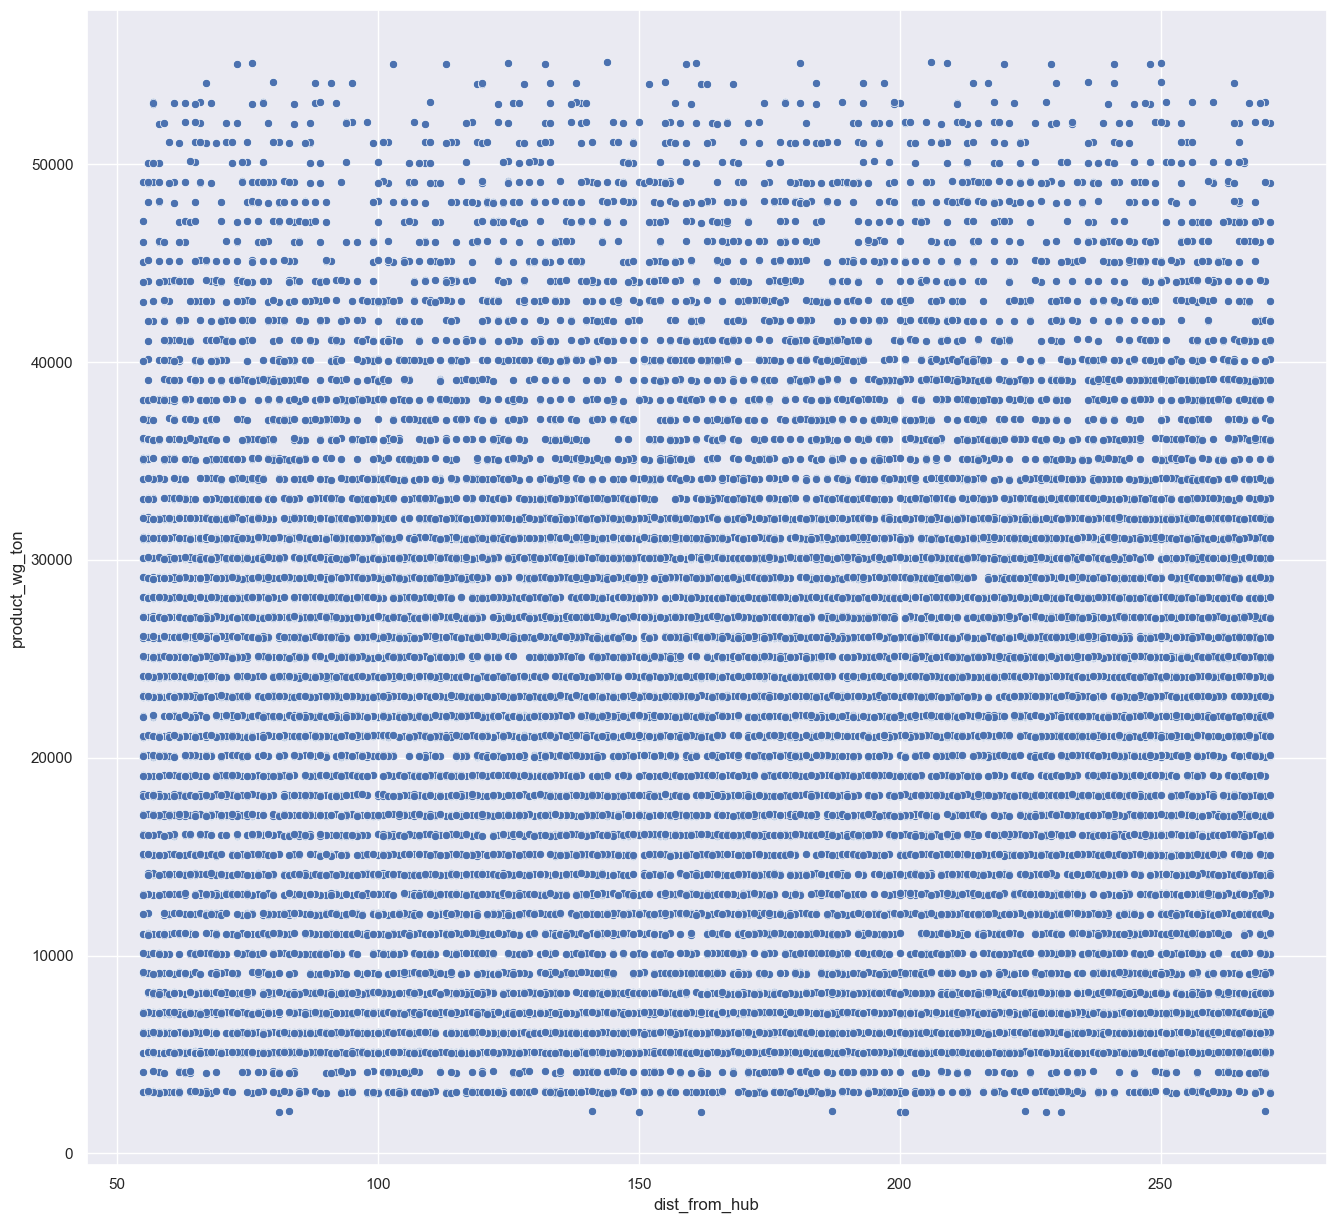

In [87]:
sns.scatterplot(x="dist_from_hub", y="product_wg_ton", data=fmcg_data, palette="");

In [88]:
def distance(x):
    if x<=90:
        return "short"
    elif x<=180:
        return "medium"
    else:
        return "long"     

In [89]:
fmcg_data["Distance Category"]=fmcg_data.dist_from_hub.apply(distance)

In [90]:
dis_refil_df=fmcg_data.groupby(["Distance Category","wh_regional_zone","wh_capacity_size", "zone"], as_index=False)["num_refill_req_l3m"].sum()

In [91]:
dis_refil_df.sort_values(by = "num_refill_req_l3m", ascending=False)

Distance Category wh_regional_zone wh_capacity_size   zone  \
45            medium           Zone 6            Large  North   
19              long           Zone 6            Large  North   
14              long           Zone 4              Mid   West   
40            medium           Zone 4              Mid   West   
16              long           Zone 5            Large  North   
42            medium           Zone 5            Large  North   
21              long           Zone 6            Large   West   
18              long           Zone 5            Large   West   
5               long           Zone 2              Mid  South   
47            medium           Zone 6            Large   West   
44            medium           Zone 5            Large   West   
31            medium           Zone 2              Mid  South   
71             short           Zone 6            Large  North   
38            medium           Zone 4              Mid  North   
12              long           Zone 4              Mid  North   
17              long           Zone 5            Large  South   
43            medium           Zone 5            Large  South   
13              long           Zone 4              Mid  South   
34            medium           Zone 3              Mid  North   
51            medium           Zone 6            Small   West   
23              long           Zone 6            Small  North   
36            medium           Zone 3              Mid   West   
49            medium           Zone 6            Small  North   
10              long           Zone 3              Mid   West   
8               long           Zone 3              Mid  North   
35            medium           Zone 3              Mid  South   
24              long           Zone 6            Small  South   
9               long           Zone 3              Mid  South   
50            medium           Zone 6            Small  South   
27            medium           Zone 1            Small  North   
4               long           Zone 2              Mid  North   
25              long           Zone 6            Small   West   
30            medium           Zone 2              Mid  North   
39            medium           Zone 4              Mid  South   
1               long           Zone 1            Small  North   
68             short           Zone 5            Large  North   
66             short           Zone 4              Mid   West   
32            medium           Zone 2              Mid   West   
28            medium           Zone 1            Small  South   
2               long           Zone 1            Small  South   
6               long           Zone 2              Mid   West   
73             short           Zone 6            Large   West   
57             short           Zone 2              Mid  South   
70             short           Zone 5            Large   West   
20              long           Zone 6            Large  South   
29            medium           Zone 1            Small   West   
69             short           Zone 5            Large  South   
3               long           Zone 1            Small   West   
64             short           Zone 4              Mid  North   
46            medium           Zone 6            Large  South   
60             short           Zone 3              Mid  North   
62             short           Zone 3              Mid   West   
61             short           Zone 3              Mid  South   
76             short           Zone 6            Small  South   
75             short           Zone 6            Small  North   
58             short           Zone 2              Mid   West   
77             short           Zone 6            Small   West   
65             short           Zone 4              Mid  South   
56             short           Zone 2              Mid  North   
53             short           Zone 1            Small  North   
54             short           Zone 1 

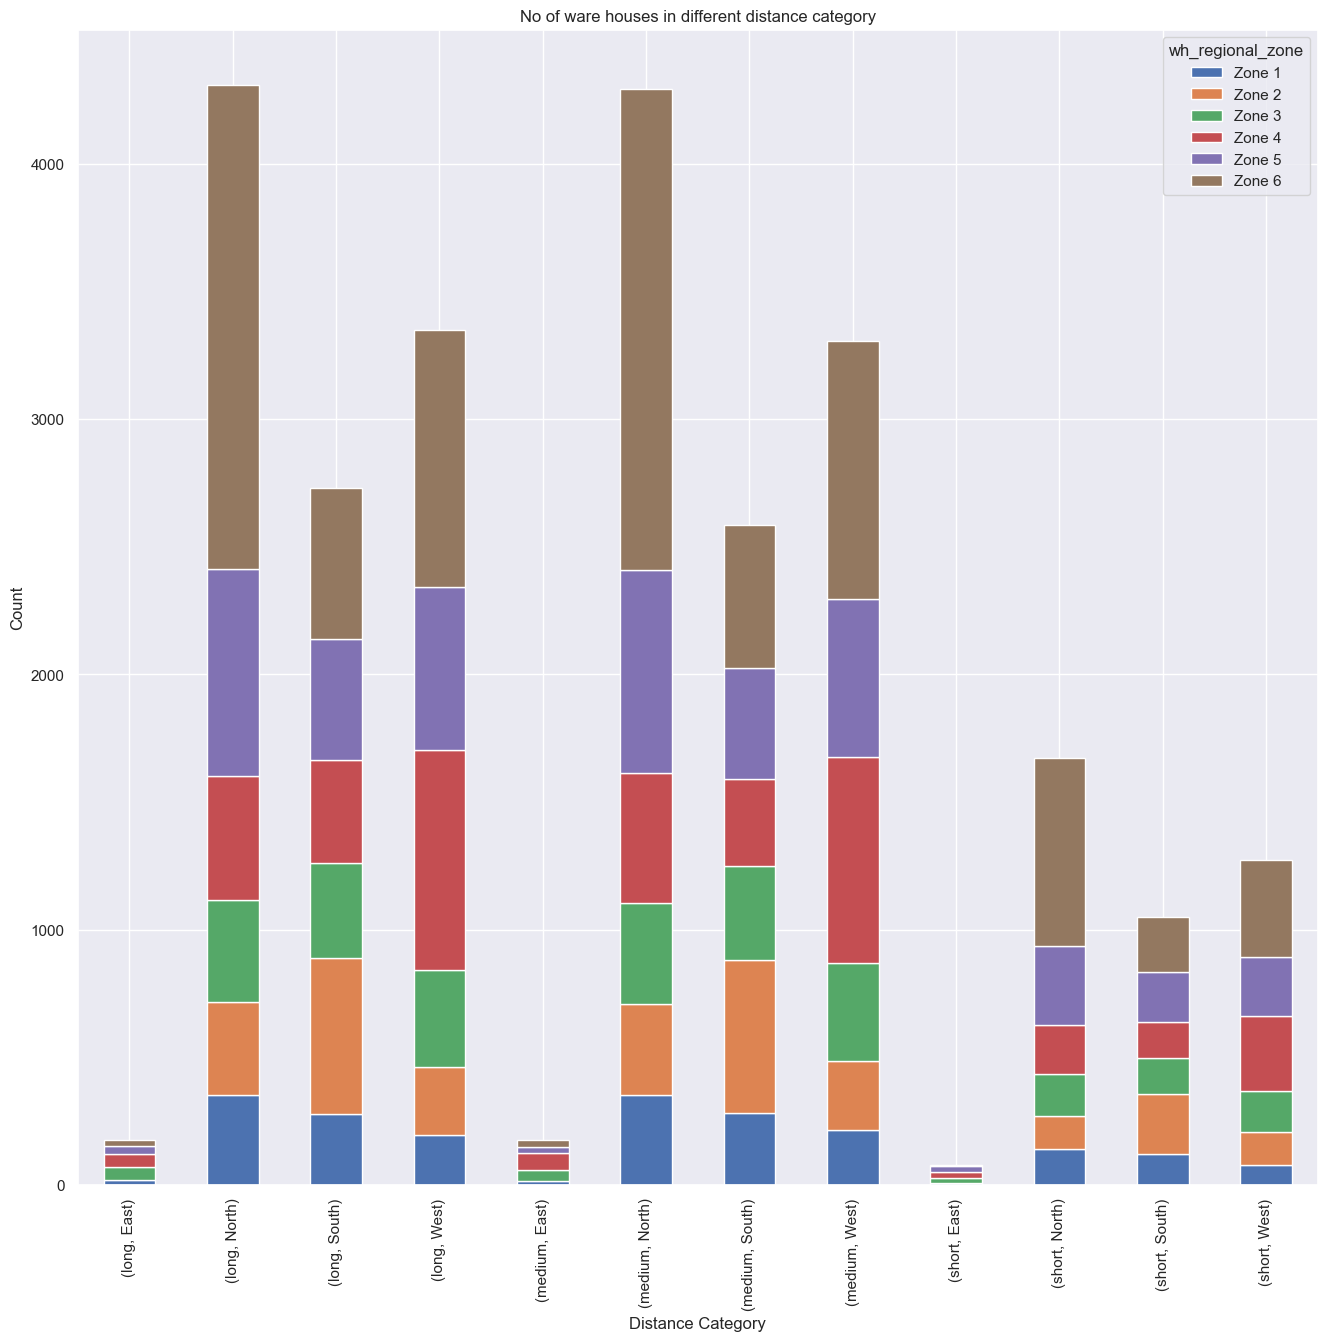

In [92]:
grouped_data = fmcg_data.groupby(["Distance Category", "wh_regional_zone", "zone"])["wh_regional_zone"].count().unstack("wh_regional_zone")
grouped_data.plot(kind='bar', stacked=True)

# Add axis labels and a title
plt.xlabel("Distance Category")
plt.ylabel('Count')
plt.title('No of ware houses in different distance category')

# Show the plot
plt.show()

In [93]:
grouped_data

wh_regional_zone         Zone 1  Zone 2  Zone 3  Zone 4  Zone 5  Zone 6
Distance Category zone                                                 
long              East    20.00     NaN   51.00   50.00   30.00   25.00
                  North  351.00  366.00  401.00  485.00  811.00 1897.00
                  South  278.00  610.00  374.00  401.00  476.00  590.00
                  West   196.00  266.00  380.00  862.00  639.00 1008.00
medium            East    14.00     NaN   43.00   67.00   24.00   26.00
                  North  351.00  357.00  395.00  510.00  795.00 1886.00
                  South  283.00  599.00  367.00  341.00  436.00  558.00
                  West   215.00  272.00  383.00  808.00  619.00 1010.00
short             East     9.00     NaN   18.00   25.00   20.00    7.00
                  North  139.00  131.00  165.00  191.00  311.00  736.00
                  South  119.00  235.00  144.00  140.00  195.00  216.00
                  West    79.00  127.00  160.00  296.00  231.00  380.00

Shipping costs: The farther the distance, the higher the shipping costs. This can be a significant factor in determining the overall profitability of a product.

Delivery time: Shipping times increase with distance, which may more likely lead to less or no supply if the refill is not done in proper time. This can impact customer satisfaction and repeat business.

Supply chain complexity: Longer distances may require more complex supply chain management, including more warehouses and transportation networks, which can increase operational costs.

The distance and number of refills required to supply a warehouse will depend on a few factors, including the size of the warehouse and the frequency of deliveries.

The type of inventory being stored may also impact the frequency and volume of deliveries. For example, warehouses that store perishable goods may require more frequent deliveries to ensure that inventory stays fresh.

when the demand and WH size is more like in case of Zone 6 North, and the distance is number, frequent shipping can be minimised to optimize the transportation costs and inventory management. This may involve working with logistics providers to develop efficient delivery schedules, implementing inventory tracking systems to better manage stock levels.

Overall, the distance and number of refills required to supply a warehouse will vary depending on a range of factors, and it's important to develop a customized supply chain strategy to meet the specific needs of the business.

## Data Distribution

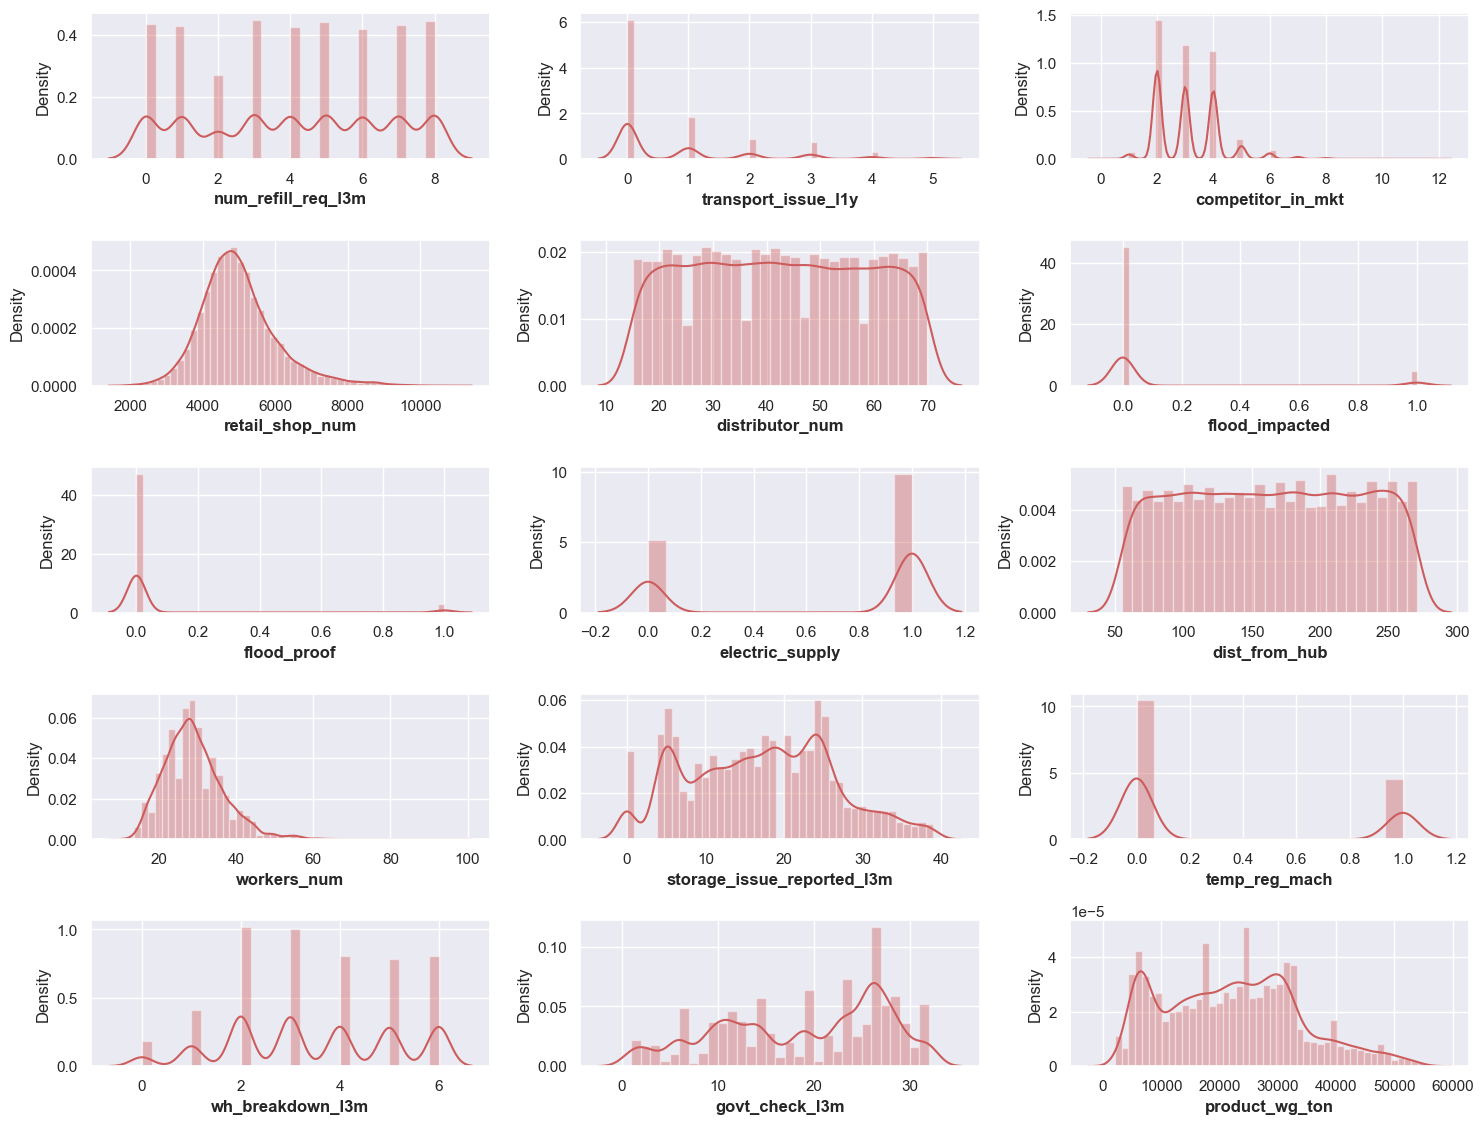

In [96]:
numeric_features = [feature for feature in fmcg_data.columns if fmcg_data[feature].dtype != 'O']

plt.figure(figsize=(15, 20))
for i, col in enumerate(numeric_features):
    plt.subplot(9, 3, i+1)
    sns.distplot(x=fmcg_data[col], color='indianred')
    plt.xlabel(col, weight='bold')
    plt.tight_layout()

### Data imputation and transformation

### Categorical data Mapping

In [97]:
fmcg_data["location_type"] = fmcg_data["location_type"].map({"Urban":0, "Rural":1})
fmcg_data["wh_capacity_size"]=fmcg_data["wh_capacity_size"].map({"Small":0, "Mid":1, "Large":2})
fmcg_data["wh_owner_type"]=fmcg_data["wh_owner_type"].map({"Rented":0, "Company Owned":1})

In [98]:
first_look(fmcg_data, "approved_wh_govt_certificate")

column name    :  approved_wh_govt_certificate
per_of_nulls   :  % 3.63
num_of_nulls   :  908
num_of_uniques :  5
Value counts   : 
 approved_wh_govt_certificate
C      5501
B+     4917
B      4812
A      4671
A+     4191
NaN     908
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------


### Encoding

In [99]:
fmcg_data["approved_wh_govt_certificate"]=fmcg_data["approved_wh_govt_certificate"].map({"C":0, "B":1, "B+":2, "A":3,"A+":4})

In [100]:
fmcg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ware_house_id                 25000 non-null  object 
 1   wh_manager_id                 25000 non-null  object 
 2   location_type                 25000 non-null  int64  
 3   wh_capacity_size              25000 non-null  int64  
 4   zone                          25000 non-null  object 
 5   wh_regional_zone              25000 non-null  object 
 6   num_refill_req_l3m            25000 non-null  int64  
 7   transport_issue_l1y           25000 non-null  int64  
 8   competitor_in_mkt             25000 non-null  int64  
 9   retail_shop_num               25000 non-null  int64  
 10  wh_owner_type                 25000 non-null  int64  
 11  distributor_num               25000 non-null  int64  
 12  flood_impacted                25000 non-null  int64  
 13  f

In [101]:
categorical_cols = fmcg_data.select_dtypes(include="object")
categorical_cols=categorical_cols.columns.values
req_cat_cols=categorical_cols[2:-1]
req_cat_cols

array(['zone', 'wh_regional_zone'], dtype=object)

In [102]:
fmcg_data = pd.get_dummies(fmcg_data, columns=req_cat_cols, drop_first=True)

In [103]:
drop_cols = ["ware_house_id", "wh_manager_id","Distance Category"]

In [104]:
df=fmcg_data.drop(columns=drop_cols)

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   location_type                 25000 non-null  int64  
 1   wh_capacity_size              25000 non-null  int64  
 2   num_refill_req_l3m            25000 non-null  int64  
 3   transport_issue_l1y           25000 non-null  int64  
 4   competitor_in_mkt             25000 non-null  int64  
 5   retail_shop_num               25000 non-null  int64  
 6   wh_owner_type                 25000 non-null  int64  
 7   distributor_num               25000 non-null  int64  
 8   flood_impacted                25000 non-null  int64  
 9   flood_proof                   25000 non-null  int64  
 10  electric_supply               25000 non-null  int64  
 11  dist_from_hub                 25000 non-null  int64  
 12  workers_num                   24010 non-null  float64
 13  s

In [106]:
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import  train_test_split, cross_val_score

## KNN Imputer for Null values

### Why KNN Imputer?
- KNNImputer by scikit-learn is a widely used method to impute missing values. It is widely being observed as a replacement for traditional imputation techniques.

- KNNImputer helps to impute missing values present in the observations by finding the nearest neighbors with the distance matrix.

- Here we Iterates through different K values and get accuracy and choose best K values.

In [110]:
X = df.drop(columns="product_wg_ton", axis=1)
y = df["product_wg_ton"]

In [111]:
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import  train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [112]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.33, random_state=42)

In [113]:
X_train.isnull().sum()

location_type                     0
wh_capacity_size                  0
num_refill_req_l3m                0
transport_issue_l1y               0
competitor_in_mkt                 0
retail_shop_num                   0
wh_owner_type                     0
distributor_num                   0
flood_impacted                    0
flood_proof                       0
electric_supply                   0
dist_from_hub                     0
workers_num                     675
storage_issue_reported_l3m        0
temp_reg_mach                     0
approved_wh_govt_certificate    592
wh_breakdown_l3m                  0
govt_check_l3m                    0
zone_North                        0
zone_South                        0
zone_West                         0
wh_regional_zone_Zone 2           0
wh_regional_zone_Zone 3           0
wh_regional_zone_Zone 4           0
wh_regional_zone_Zone 5           0
wh_regional_zone_Zone 6           0
dtype: int64

### Robust Scaling

In [114]:
robust_scalar = RobustScaler()
X1 = robust_scalar.fit_transform(X_train)

In [115]:
from sklearn.model_selection import GridSearchCV
# Create pipeline with KNN imputer and random forest regressor
pipeline = Pipeline([
    ('imputer', KNNImputer()),
    ('regressor', RandomForestRegressor())
])
# Define parameter grid for KNN imputer
param_grid = {
    'imputer__n_neighbors': [3, 5, 7],
    'imputer__weights': ['distance']
}
# Perform grid search with pipeline and parameter grid
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=2)

# Fit grid search on dataset
grid_search.fit(X1, y_train)
# Print best hyperparameters and score
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")


KeyboardInterrupt



### Pipeline for KNN imputer

In [122]:
pipeline = Pipeline(steps=[("robust_scalar" , RobustScaler()),("imputer" , KNNImputer(n_neighbors=5, weights='distance'))])
pipeline.fit(X_train)
# Transform numerical data to fill in missing values
x_imputed  = pipeline.transform(X_train)
x_imputed = pd.DataFrame(x_imputed, columns=X_train.columns)

### Feature Selection

In [ ]:
multicolinearity_control(X)

In [123]:
X_vif=x_imputed.copy()

### Variance Inflation Factor  

In [124]:
# !pip install statsmodels

In [125]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.formula.api import ols

In [126]:
X_vif["intercept"]=1

In [127]:
def VIF(df):
    x=1
    while x:
        VIF = pd.DataFrame()
        VIF['Independent_Variables'] = df.columns
        VIF['VIF'] = [vif(df.values, i) for i in range(df.shape[1])]
        VIF = VIF.set_index('Independent_Variables').drop(index = 'intercept').T
        for i, value in enumerate(VIF.values[0]):
            if value>5:
                x=1
                df.drop(columns=VIF.columns[i], axis=1, inplace=True)
                break
            else:
                x=0
    return VIF

In [128]:
VIF(X_vif)

Independent_Variables  location_type  wh_capacity_size  num_refill_req_l3m  \
VIF                             1.01              1.15                1.08   

Independent_Variables  transport_issue_l1y  competitor_in_mkt  \
VIF                                   1.03               1.19   

Independent_Variables  retail_shop_num  wh_owner_type  distributor_num  \
VIF                               1.05           1.08             1.00   

Independent_Variables  flood_impacted  flood_proof  electric_supply  \
VIF                              1.06         1.02             1.20   

Independent_Variables  dist_from_hub  workers_num  storage_issue_reported_l3m  \
VIF                             1.00         1.17                        1.22   

Independent_Variables  temp_reg_mach  approved_wh_govt_certificate  \
VIF                             1.18                          1.12   

Independent_Variables  wh_breakdown_l3m  govt_check_l3m  zone_South  \
VIF                                1.17            1.19        1.36   

Independent_Variables  zone_West  wh_regional_zone_Zone 2  \
VIF                         1.36                     1.33   

Independent_Variables  wh_regional_zone_Zone 3  wh_regional_zone_Zone 4  \
VIF                                       1.36                     1.49   

Independent_Variables  wh_regional_zone_Zone 6  
VIF                                       1.52

In [129]:
X_vif.drop(columns="intercept", inplace=True)
X_vif

location_type  wh_capacity_size  num_refill_req_l3m  \
0              -1.00              0.00               -0.25   
1               0.00             -1.00                1.00   
2               0.00              1.00                1.00   
3               0.00              1.00                0.50   
4               0.00              0.00                0.25   
...              ...               ...                 ...   
16745           0.00              0.00                0.50   
16746           0.00              1.00               -1.00   
16747          -1.00              0.00                0.75   
16748           0.00              0.00               -0.75   
16749           0.00              1.00               -0.50   

       transport_issue_l1y  competitor_in_mkt  retail_shop_num  wh_owner_type  \
0                     0.00               0.00             0.88          -1.00   
1                     0.00              -0.50             0.53          -1.00   
2                     0.00               0.50             2.48           0.00   
3                     3.00               0.00            -0.15           0.00   
4                     0.00               0.50            -0.14          -1.00   
...                    ...                ...              ...            ...   
16745                 0.00               0.50            -0.42           0.00   
16746                 1.00               0.50             1.81           0.00   
16747                 1.00               0.00            -0.03          -1.00   
16748                 0.00              -0.50             0.04           0.00   
16749                 0.00               0.00             2.04          -1.00   

       distributor_num  flood_impacted  flood_proof  electric_supply  \
0                 0.15            0.00         0.00            -1.00   
1                -0.93            0.00         0.00            -1.00   
2                -0.74            0.00         0.00             0.00   
3                -0.89            1.00         0.00             0.00   
4                -0.70            0.00         0.00             0.00   
...                ...             ...          ...              ...   
16745             0.26            0.00         0.00             0.00   
16746            -0.70            0.00         0.00             0.00   
16747            -0.74            0.00         0.00            -1.00   
16748             0.74            0.00         0.00             0.00   
16749             0.74            0.00         0.00             0.00   

       dist_from_hub  workers_num  storage_issue_reported_l3m  temp_reg_mach  \
0               0.55         1.11                        0.43           1.00   
1              -0.13         0.47                       -0.93           0.00   
2               0.43        -0.11                        0.14           0.00   
3               0.30         0.22                       -0.21           0.00   
4               0.14         0.33                       -0.93           1.00   
...              ...          ...                         ...            ...   
16745          -1.00        -0.33                        0.07           0.00   
16746           0.59        -0.22                       -0.14           0.00   
16747           0.21        -0.44                        0.14           0.00   
16748           0.58        -0.22                        0.07           0.00   
16749           0.19         1.56                        0.07           0.00   

       approved_wh_govt_certificate  wh_breakdown_l3m  govt_check_l3m  \
0                              1.00             -0.33            0.33   
1                              0.50              0.33           -0.80   
2                              0.00              1.00           -1.00   
3                              0.00              1.00            0.20   
4                              0.50             -0.33            0.33   
...                      

### OLS method for feature selection

In [ ]:
# def ols_method(df, final_df):
#     ft=' + '.join(df)
#     formula = "product_wg_ton ~ "+ft
#     lm_fit_multi = ols(formula, data = final_df).fit()
#     return lm_fit_multi.summary()
# ols_method(df_vif, final_df)

### Ensemble techinque to select the most important features

In [ ]:
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor
# import pandas as pd



# # create Random Forest classifier
# rf = RandomForestRegressor()

# # fit the model on the data
# rf.fit(imp_feat, y_train)

# # get feature importances
# importances = rf.feature_importances_

# # create a dataframe to display feature importances
# feature_importances = pd.DataFrame({'feature': imp_feat.columns, 'importance': importances})
# feature_importances = feature_importances.sort_values(by='importance', ascending=False).reset_index(drop=True)

# # print the feature importances
# print(feature_importances)
# import matplotlib.pyplot as plt

# # plot feature importances in descending order
# plt.figure(figsize=(10, 6))
# plt.bar(feature_importances['feature'], feature_importances['importance'])
# plt.xticks(rotation=90)
# plt.xlabel('Feature')
# plt.ylabel('Importance')
# plt.title('Feature Importances')
# plt.show()

We cannot delete the features ware house region and zone columns obtained from result of VIF

### Lasso regularization for feature selection

In [ ]:
x_imputed_test  = pipeline.transform(X_test)
x_imputed_test = pd.DataFrame(x_imputed_test, columns=X_test.columns)

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score


# Fit Lasso regression model with alpha=0.1
lasso = Lasso(alpha=0.01)
lasso.fit(x_imputed, y_train)

# Print the selected features based on the non-zero coefficients
print("Lasso selected features:", x_imputed.columns[lasso.coef_ != 0])

# Evaluate the model on the test set
y_pred = lasso.predict(x_imputed_test)
print("Lasso R2 score:", r2_score(y_test, y_pred))

### Model Building and Evaluation

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
# !pip install xgboost

### Initialize Default Models in a dictionary

In [ ]:
# Dictionary which contains models for experiment
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(), 
}

In [ ]:
def evaluate_reg(true, predicted):
    rmse = mean_squared_error(true, predicted, squared=False)
    r_score = r2_score(true, predicted)
    return rmse, r_score

In [ ]:
def evaluate_models(X_train, y_train, X_test, y_test, models):
    
    models_list = {}
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model
        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
      
        # Train set performance
        model_train_rmse, model_train_r2_score =evaluate_reg(y_train, y_train_pred)
        
        # Test set performance
        model_test_rmse, model_test_r2_score =evaluate_reg(y_test, y_test_pred)
        
        model_ = list(models.keys())[i]

        print(list(models.keys())[i])
        # models_list.append(list(models.keys())[i])

        print('Model performance for Training  set')
        print('- rmse: {:.4f}'.format(model_train_rmse))
        print('- r2 score: {:.4f}'.format(model_train_r2_score))
        
        print('----------------------------------')
        
        print('Model performance for Test set')
        print('- rmse: {:.4f}'.format(model_test_rmse))
        print('- r2 score: {:.4f}'.format(model_test_r2_score))
        
 
        print('\n')
    return pd.DataFrame({'original test set':y_test, 'predictions': y_test_pred}).head()

### Model result and predictions

In [ ]:
evaluate_models(x_imputed,y_train,x_imputed_test,y_test, models)

In [ ]:
cv_x_imputed = x_imputed.to_numpy()
cv_y_train = y_train.to_numpy()

### Cross validation

In [ ]:
import numpy as np

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
for train_index, test_index in kfold.split(cv_x_imputed):
    # Split the data into training and testing sets for this fold
    X_fold_train, X_fold_test = cv_x_imputed[train_index], cv_x_imputed[test_index]
    y_fold_train, y_fold_test = cv_y_train[train_index], cv_y_train[test_index]
    
    # Train the model on the training data for this fold
    model = GradientBoostingRegressor()
    model.fit(X_fold_train, y_fold_train)
    
    # Evaluate the performance on the testing data for this fold
    y_fold_pred = model.predict(X_fold_test)
    fol_score = r2_score(y_fold_test, y_fold_pred)
    scores.append(fol_score)

print("Average Score:", np.mean(scores))

#### Gradient Boosting is giving more accuracy and less error when compared to other model

### Gradient Boosting is the best model to predict the optimum weight of the product to be shipped to the warehouse

In [ ]:
!pip install lazypredict

In [ ]:
# Importing necessary libraries
from lazypredict.Supervised import LazyClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Load the Iris dataset
data = load_iris()
X = data.data
y = data.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the LazyClassifier
clf = LazyClassifier()

# Fit the LazyClassifier on the training data and get the predictions
models = clf.fit(X_train, X_test, y_train, y_test)

# Print the summary of model performances
print(models)